### ~ 15 mins

In [1]:
#default_exp skullstrip

### set `data.yaml`

In [2]:
import yaml,os

In [25]:
os.environ['YAML_DATA']="/home/turgutluk/Vent_Seg_Project/dev/configs/data.yaml"

In [26]:
with open(os.environ.get('YAML_DATA', '../data.yaml')) as f: data_config = yaml.load(f.read(), yaml.FullLoader)

In [27]:
data_config

{'input': {'ATLAS_PATH': '/data/public/PICARE_BMETS_Raw_DICOM_Files',
  'MR_PATH': '/data/public/PICARE_SEGMENTATION_BRAINVENT_MR_V1',
  'CT_PATH': '/data/public/Training_CT_Raw_DICOM_Files',
  'MR_TEST2_PATH': '/data/public/Testing_MR_Raw_DICOM_Files',
  'CT_TEST2_PATH': '/data/public/Testing_CT_Raw_DICOM_Files'},
 'output': {'ATLAS': '/home/turgutluk/data/ventricles_data/atlas',
  'MR': '/home/turgutluk/data/ventricles_data/mr',
  'CT': '/home/turgutluk/data/ventricles_data/ct'},
 'csv_splits': {'ATLAS': '/home/turgutluk/data/ventricles_data/csvs/atlas_splits_df.csv',
  'MR': '/home/turgutluk/data/ventricles_data/csvs/mr_splits_df.csv',
  'CT': '/home/turgutluk/data/ventricles_data/csvs/ct_splits_df.csv'}}

### read -> skull strip -> save

In [6]:
#export
from fastai2.medical.imaging_roi import *
from fastai2.medical.imaging import dicom_windows
from fastai2 import *
from fastai2.torch_core import *
from fastai2.core import *
from fastai2.basics import *

In [7]:
from local.dicom2tensor import _plot_voxel

In [8]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [9]:
# define input and output paths
input_paths = types.SimpleNamespace(
    ATLAS_PATH=data_config['input']['ATLAS_PATH'],
    MR_PATH=data_config['input']['MR_PATH'],
    CT_PATH=data_config['input']['CT_PATH'],
    MR_TEST2_PATH=data_config['input']['MR_TEST2_PATH'],
    CT_TEST2_PATH=data_config['input']['CT_TEST2_PATH'],
)

output_paths = types.SimpleNamespace(
    ATLAS=data_config['output']['ATLAS'],
    MR=data_config['output']['MR'],
    CT=data_config['output']['CT'])

In [10]:
# Patient Position Attribute - https://dicom.innolitics.com/ciods/raw-data/general-series/00185100
# We don't normalize it by patient position and leave it as original
# This in a way acts as an inherent data augmentation

### `[notebook run #1]` - `read -> skull strip -> save`

You can use the following cells to skull strip image tensors using brain masks. This data will be used for ventricle segmentation task. Code below will get all the files in a given output path which we saved our tensors in previous section: `dicom2tensor`. You may choose `ATLAS`, `MR`, `CT` output_paths for skull stripping or you can also pass a parent directory if you saved all outputs to the same parent directory as it is suggested.

In [12]:
#export 
def _skull_strip_and_save(o):
    "skull strips image using brain mask and saves new image"
    p = o.parent
    suid = o.name.split('_')[0]
    image = torch.load(p/f"{suid}_image.pt")
    brain_mask = torch.load(p/f"{suid}_brain_mask.pt")   
    skull_stripped_image = image*brain_mask
    torch.save(skull_stripped_image, p/f"{suid}_skull_stripped_image.pt")

In [14]:
# I can either go with a specific modality directory
output_path = output_paths.MR; print(output_path)
# or I can use parent directory which is same in my case for MR, CT and ATLAS to skull strip all data in one go
output_path = Path(output_paths.MR).parent; print(output_path)

/home/turgutluk/data/ventricles_data/mr
/home/turgutluk/data/ventricles_data


In [99]:
# collect all data files within the given output path and do skull stripping
# 15 mins for all data
files = get_files(output_path, extensions=['.pt'])
parallel(_skull_strip_and_save, files, n_workers=defaults.cpus//2)

(#7504) [None,None,None,None,None,None,None,None,None,None...]

### `script` - Don't execute cells below!

These cells are converted into a python script in `local/skullstrip.py` which you can use instead of running in noteboook

In [20]:
#export 
import yaml
with open(os.environ.get('YAML_DATA', '../data.yaml')) as f: data_config = yaml.load(f.read(), yaml.FullLoader)

# define input and output paths
input_paths = types.SimpleNamespace(
    ATLAS_PATH=data_config['input']['ATLAS_PATH'],
    MR_PATH=data_config['input']['MR_PATH'],
    CT_PATH=data_config['input']['CT_PATH'],
    MR_TEST2_PATH=data_config['input']['MR_TEST2_PATH'],
    CT_TEST2_PATH=data_config['input']['CT_TEST2_PATH'],
)

output_paths = types.SimpleNamespace(
    ATLAS=data_config['output']['ATLAS'],
    MR=data_config['output']['MR'],
    CT=data_config['output']['CT'])

In [ ]:
#export 
from time import perf_counter
@call_parse
def main(output_path:Param("Directory that have data prep results", str)):
    "Read tensors, skull strip images and save it as a new image"
    start = perf_counter()
    
    output_path = Path(output_paths.__dict__[output_path])
    files = get_files(output_path, extensions=['.pt'])
    parallel(_skull_strip_and_save, files, n_workers=defaults.cpus//2)
    
    end = perf_counter()
    print(f"Total time taken {end-start} seconds")

### Export

In [29]:
from local.notebook.export import notebook2script
notebook2script("1b) skull strip.ipynb")

Converted 1b) skull strip.ipynb.


### Visualize

You may visualize images before and after skull stripping

In [15]:
# pick a random file
files = get_files(output_path, extensions=['.pt'])
o = np.random.choice(files)

In [16]:
# extract study instance uid
suid = o.name.split("_")[0]
p = o.parent

In [22]:
# read image and skull stripped image for that study instance
skull_stripped_image = torch.load(p/f"{suid}_skull_stripped_image.pt")
image = torch.load(p/f"{suid}_image.pt")

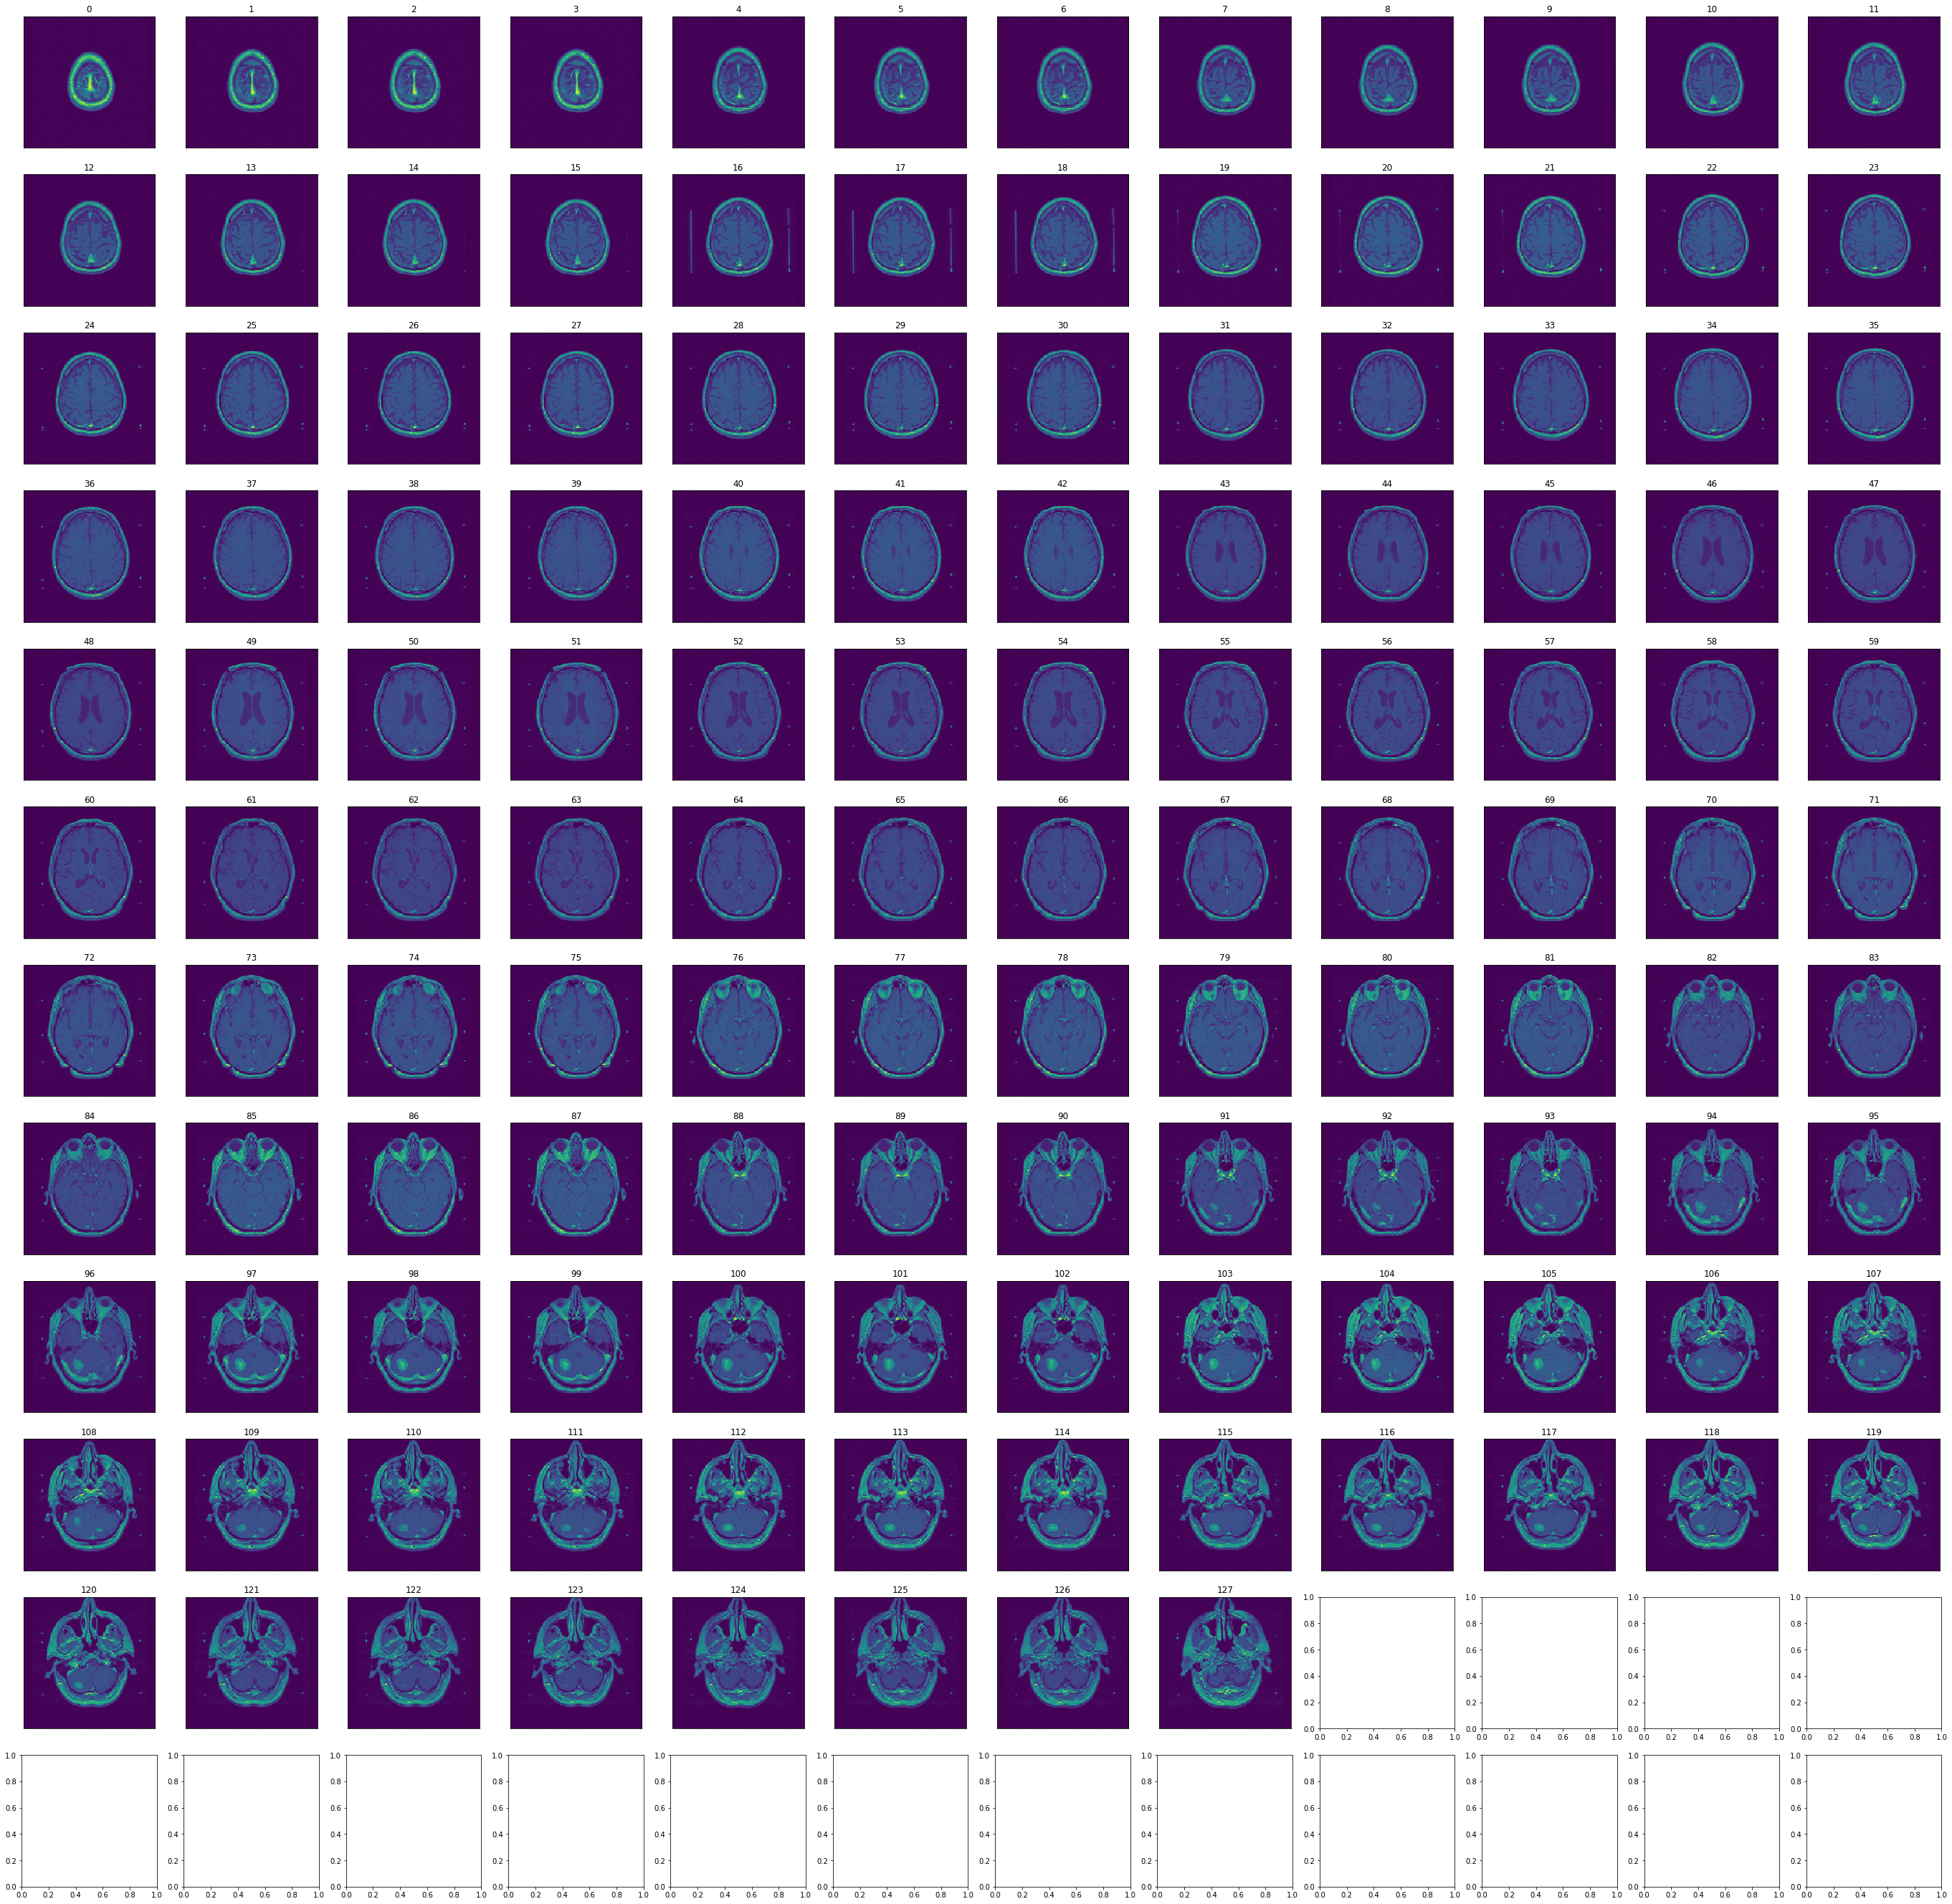

In [23]:
_plot_voxel(image)

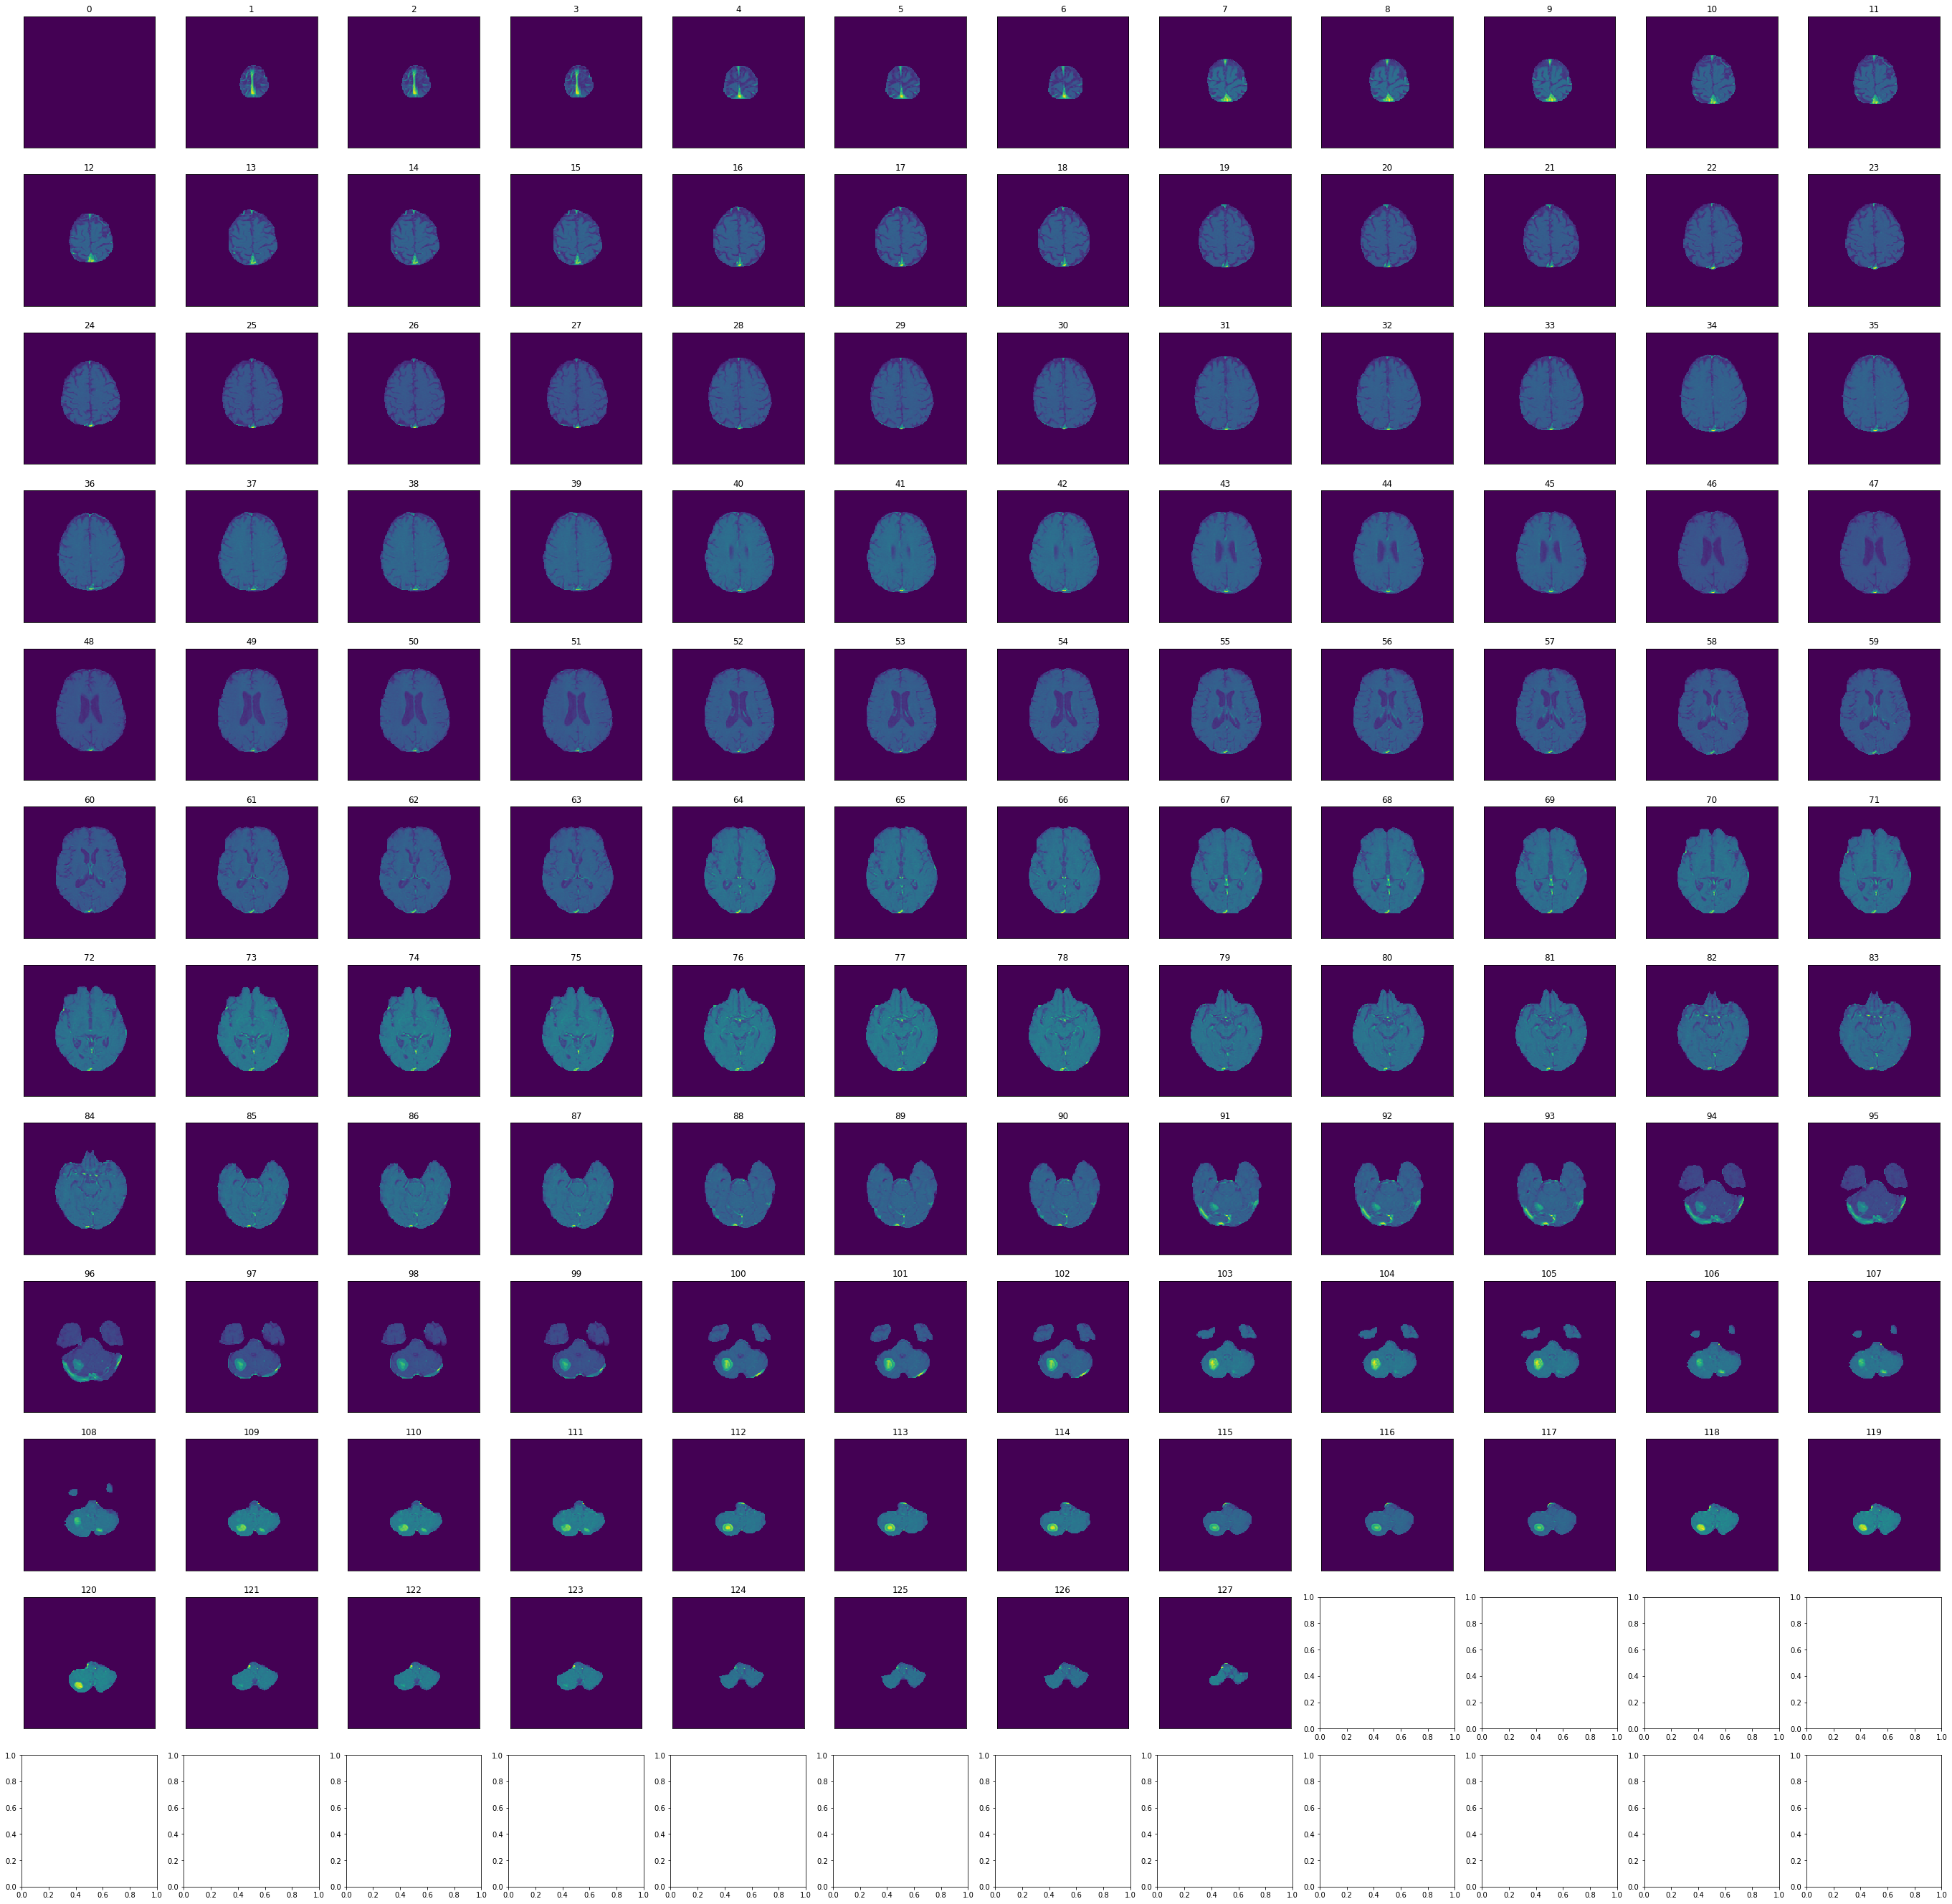

In [24]:
_plot_voxel(skull_stripped_image)

### fin